In [2]:

## imports section ##
from scipy.optimize import minimize
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
import time as time
#import json
import pickle

# 3rd party packages
import qiskit as qk
import qiskit.providers.aer.noise as noise
import tenpy as tp

## custom things
from isonetwork import QKParamCircuit, IsoTensor
from networks import IsoMPS
import basic_circuits as circuits
import mps

## TENPY FUNCTION DEFINITIONS ##
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import asConfig
from tenpy.networks.site import SpinHalfSite
from tenpy.networks.mpo import MPO
from tenpy.networks.mps import MPS

# importing thermal state library
from thermal_state import thermal_state

In [3]:

# HYPERPARAMETERS ##
# model (xxz)
J = 1 # spin-exchange
Delta = 1.25 # Ising-anisotropy
hz = 0 # z-field
T = 0 # temperature
# ansatz parameters
nb = 2 # number of bond-qubits
L = 10 # repetition of unit-cell
l_uc = 2 # number of sites in unit cell
N = L * l_uc
n_site_param = 2*nb # number of circuit parameters per site
# number of bond circuit parameters
use_bond_prep = False

if use_bond_prep:
    if nb==1: n_bond_params=3
    elif nb==2: n_bond_params=15 
else:
    n_bond_params=0

circuits for each site in uc:


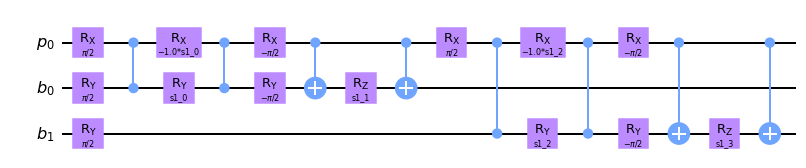

In [4]:

## CREATE ISOMPS FROM PARAMETERIZED CIRCUIT ANSATZ ##
# initialize registers

preg = qk.QuantumRegister(1,'p') # physical qubits
breg = qk.QuantumRegister(nb,'b') # bond qubits
#creg = qk.ClassicalRegister(L*l_uc+nb,'m') # classical register to hold measurement outcomes

## Bond-state prep-circuit ##
bond_prep_params = [qk.circuit.Parameter('bp_'+str(j)) 
                    for j in range(n_bond_params)]
bond_prep_circ = qk.QuantumCircuit(breg)
if use_bond_prep:
    if nb==1: circuits.add_1q_circ(bond_prep_circ, breg[0], bond_prep_params) 
    elif nb==2: circuits.add_su4_circ(bond_prep_circ, breg[0],breg[1], bond_prep_params) 
else:
    bond_prep_circ.ry(0.234,breg)

# turn into custom parameterized circuit object
bond_prep_pcirc = QKParamCircuit(bond_prep_circ,bond_prep_params)


## Site Circuits ##
# create list of circuits, one for each site in the unit cell (uc)
site_circs = [qk.QuantumCircuit(preg,breg) for j in range(l_uc)]
# create a list of parameter-lists, (one list of parameters per site in uc)
site_circ_params = [[qk.circuit.Parameter('s'+str(j)+'_'+str(k))
                     for k in range(n_site_param)] 
                    for j in range(l_uc)]
site_pcircs=[] # list of QKParamCirc's for each site in uc
for j in range(l_uc):
    if j%2==0: site_circs[j].x(preg[0]) # alternating 10101010... for physical qubit
    
    # star circuit of xxz-type 2-qubit gates
    for k in range(nb): 
        circuits.add_xxz_circ(site_circs[j], 
                              preg[0], breg[k], 
                              site_circ_params[j][2*k:2*(k+1)])
    # combine into parameterized circuit
    site_pcircs += [QKParamCircuit(site_circs[j], site_circ_params[j])]

# create holopy isoMPS
psi = IsoMPS(preg,breg,site_pcircs,boundary_circuit=bond_prep_pcirc,L=L)

print('circuits for each site in uc:')
site_circs[1].draw('mpl')

In [6]:

## defining optimized circuit params, Hamiltonian, and gs (T = 0) ##

def energy_tp(param_vals,*args):
    """
    function to calculate energy using MPO/MPS contraction in tenpy
    inputs:
        - param_vals = dict {parameter:value}
        - *args, 
            args[0] should be psi: state as IsoMPS
            args[1] should be H_mpo: Hamiltonian as MPO
            args[2] should be N: number of sites
        (input made this way to be compatible w/ scipy.optimize)
    outputs:
        - float, <psi|H|psi> computed w/ tenpy
    """
    # parse inputs
    psi = args[0] # state as isoMPS    
    H_mpo = args[1] # Hamiltonian as tenpy MPO
    N = args[2]
    param_dict = dict(zip(psi.param_list,param_vals))
    
    # convert state from holoPy isoMPS to tenpy MPS
    site = SpinHalfSite(conserve = None)
    state_list = psi.L*psi.tensors(param_dict)
    B_arrs = [np.swapaxes(tensor,1,2) for tensor in state_list]
    B_arrs[0] = B_arrs[0][:,0:1,:]
    B_arrs[-1] = B_arrs[-1][:,:,0:1]
    psi_tp = MPS.from_Bflat([site]*N,B_arrs,bc = 'finite',dtype=complex,form=None) 
    
    psi_tp.canonical_form()
    psi_tp.convert_form(psi_tp.form)
    # compute energy
    E = (H_mpo.expectation_value(psi_tp)).real
    return E


def xxz_mpo(J, Delta, hz, method, N=None):
    """
    based on quantumtensor.pks.mpg.de/wp-content/uploads/2016/06/notes_1.pdf
    """
    if method == 'method_I' or method == 'method_II':
        
        ze = np.zeros((2,2),dtype=complex) # 2x2 zero matrices
        # Pauli matrices and spin operators
        sigmax = np.array([[0., 1.], [1., 0.]],dtype=complex)
        sigmay = np.array([[0., -1j], [1j, 0.]],dtype=complex)
        sigmaz = np.array([[1., 0.], [0., -1.]],dtype=complex)
        Id = np.eye(2)
        Sx, Sy, Sz = 0.5*sigmax, 0.5*sigmay, 0.5*sigmaz
        H0 = np.array([[Id,ze,ze,ze,ze],
                       [Sx,ze,ze,ze,ze],
                       [Sy,ze,ze,ze,ze],
                       [Sz,ze,ze,ze,ze],
                       [-hz*Sz,J*Sx,J*Sy,J*Delta*Sz,Id]],dtype=complex)
        
        if method == 'method_I': 
            # changing axis ordering to: p_out, b_out, p_in, b_in 
            H = np.swapaxes(np.swapaxes(H0,0,2),2,3) 
        else:   
            H = H0
            
    elif method == 'tenpy':
        site = SpinHalfSite(None)
        Id, Sp, Sm, Sz = site.Id, site.Sp, site.Sm, 2*site.Sz
        Sx, Sy = (Sp + Sm), -1j*(Sp - Sm)
        H_bulk = [[Id, Sx, Sy, Sz, -hz * Sz],
                  [None, None, None, None, J * Sx],
                  [None, None, None, None, J * Sy],
                  [None, None, None, None, J * Delta * Sz],
                  [None, None, None, None, Id]]
        
        H_first = [H_bulk[0]] # first row
        H_last = [[row[-1]] for row in H_bulk] # last column
        H_list = [H_first] + [H_bulk]*(N - 2) + [H_last]  
        H = thermal_state.network_from_cells(H_list,'MPO',N,None,None,None,'tenpy',T)      
    return H


# defining boundary vectors for Hamiltonian MPO and state
chi_H = xxz_mpo(J,Delta,hz,'method_I',N=None)[0,:,0,0].size # size of Hamiltonian bond leg dimension

# Hamiltonian MPO boundary vectors
H_bvecl = None
H_bvecr = np.zeros(chi_H)
H_bvecr[-1] = 1
bdry_vecs2 = [H_bvecl,H_bvecr]

# state boundary vectors (for "method_I" option)
state_bvecl = None
state_bvecr = None
bdry_vecs1 = [state_bvecl,state_bvecr]

# starting point for parameters
x0 = np.pi*np.random.randn(psi.n_params) 
t0 = time.time()
args = (psi,xxz_mpo(J,Delta,hz,'tenpy',N),N)
opt_result = minimize(energy_tp,x0,args=args,method='BFGS')
tf = time.time()

# set parameters to previously optimized values
opt_vals = opt_result.x
opt_params = dict(zip(psi.param_list,opt_vals))
E_gs_tp = opt_result.fun
print('Optimization done, elapsed time: {}'.format(tf-t0))
print('Optimized parameters')
print(opt_params)

Optimization done, elapsed time: 73.7045373916626
Optimized parameters
{Parameter(s0_0): -5.570931669330977, Parameter(s0_1): -5.646958123362494, Parameter(s0_2): 2.0274508080292644, Parameter(s0_3): -8.12052081984598, Parameter(s1_0): -4.832818282954784, Parameter(s1_1): 0.6590409982027824, Parameter(s1_2): -0.7987592420232387, Parameter(s1_3): 0.313173134233049}


In [9]:

# free energy computations using density matrix
def free_energy(params,*args):
    """
    Free energy (using density matrix)
    """
    psi = args[0]
    Hamiltonian = args[1]
    chi_H = args[2]
    T = args[3]
    method = args[4]
    prob_params = args[5]
    bdry_vecs1 = args[6]
    bdry_vecs2 = args[7]
    
    params1 = dict(zip(psi.param_list,params))
    tensors = psi.as_mpo(params1).tensors
    params2 = np.concatenate((prob_params,list(params)))
    
    F = thermal_state.free_energy(tensors,params2,'density_matrix',
                                  L,Hamiltonian,T,chi_H,bdry_vecs1,
                                  bdry_vecs2,method,None)   
    return F


#rng = np.random.default_rng() 
#probs_params = rng.uniform(high=2*np.pi,size =2)
probs_params = [1,2]

args2 = (psi,xxz_mpo(J,Delta,hz,"method_II",N),chi_H,T,"method_II",probs_params,bdry_vecs1,bdry_vecs2)

new_params = np.concatenate((probs_params,list(opt_vals)))
result2 = minimize(free_energy,x0=new_params,args=args2,method='nelder-mead')

print(f'Optimized pure energy : {E_gs_tp/N}')
print(f'Free energy (method II): {result2.fun}, Temperature: {T}')

Optimized pure energy : -1.823287284061151
Free energy (method II): -1.8138341212844382, Temperature: 0
